In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from collections import OrderedDict
import torch
torch.manual_seed(0)
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
from abcd.local.paths import output_path
from abcd.data.read_data import get_subjects_events_sf, subject_cols_to_events
import abcd.data.VARS as VARS
from abcd.data.define_splits import SITES, save_restore_sex_fmri_splits
from abcd.data.divide_with_splits import divide_events_by_splits
from abcd.data.var_tailoring.normalization import normalize_var
from abcd.data.pytorch.get_dataset import PandasDataset
from datetime import datetime

#regresssion-specific imports
from abcd.models.regression.MLPRegressor import MLPRegressor, LinearRegressor, MLPRegressorCustom
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from abcd.training.RegressorTrainer import RegressorTrainer

#plotting
import matplotlib.pyplot as plt
import pygal
from abcd.plotting.pygal.rendering import display_html
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from abcd.plotting.seaborn.confusion_matrix import plot_confusion_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [277]:
from abcd.analysis.gnn import preprocess_data, construct_networkx_graph, visualize_graph, construct_pyg_datapoint

# Define device and config

In [201]:
# Determine device for training (TODO: figure out why doesn't work with mps)
device = "cpu" #("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using {} device".format(device))

Using cpu device


In [287]:
config = {'target_col': 'kbi_sex_assigned_at_birth',
          'features': ['fmri'], # 'fmri_subcortical'
          'batch_size': 64,
        }

# Preprocess data

In [288]:
dataloaders, events_train, events_id_test, events_ood_test, labels, feature_cols = preprocess_data(config)

There are 9749 subjects and 19327 visits with imaging
Leaving baseline visits, we have 9377 events

There are 9377 visits after adding the target and removing NAs

Labels: [1.0, 2.0]

4880 visits with Male target
4497 visits with Female target


adding fmri gordon network features

Nr. events train: 7283, val: 1804, test: 
Shape of X: torch.Size([64, 169])
Shape of y: torch.Size([64]) torch.int64


# Construct and display networkx graph example

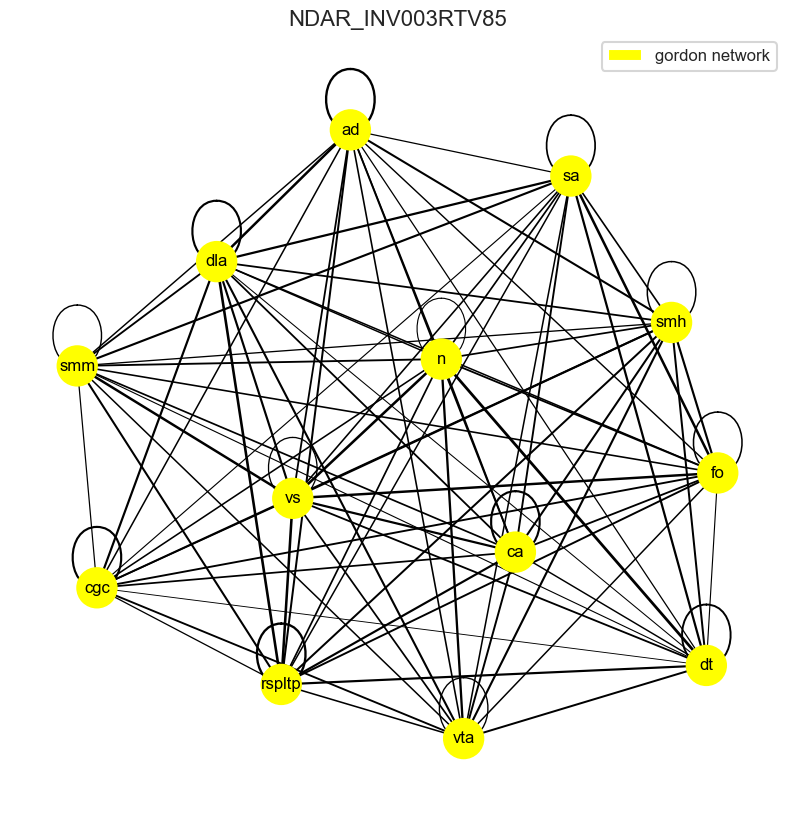

In [291]:
row_idx = 0
src_subject_id = events_train.iloc[row_idx]['src_subject_id']

G = construct_networkx_graph(config, events_train, row_idx)
visualize_graph(G, config, title=src_subject_id)

## convert networkx graph to PyTorch Geometric graph

In [292]:
G_pyg = from_networkx(G)
G_pyg

Data(edge_index=[2, 169], type=[13], weight=[169], num_nodes=13)

# Construct PyTorch Geometric graph & datapoint from scratch

In [293]:
row_idx = 0
datapoint = construct_pyg_datapoint(config, events_train, row_idx)
print(datapoint)


Data(x=[13], edge_index=[169], edge_attr=[169], y=1.0)


In [ ]:
events_train, events_id_test, events_ood_test

